# To complete!:
* net and electricity generation, values need to verified and matched with visu
* loop and read all json and csv according to the hash and param_dict
        * different sets of plots corresponding to each parameter


# Batch runs

will be moved to a seperate ipynb, 
watch out for : pv df  
heating rods, aggregate for all tanks!  
electricity demand

In [35]:
import os
import pandas as pd
import json
import plotly.graph_objects as go
import plotly.io as pio
import sys
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [36]:
cwd  = os.path.dirname(os.path.abspath("__file__")) 
datapath = os.path.join(cwd, '..', 'data', 'outputs')

In [37]:
# sys.path.insert(0,os.path.join(cwd, '..'))
# from src.utils.visu import calc_energy

In [38]:
step_size = 15 * 60

In [39]:
def calc_energy(vars):
    for i in range(len(vars)):
        vars[i] = vars[i].sum() * step_size/3600
    return np.abs(vars)

In [40]:
# load all the changes jsons, create different hash lists, indicating different changed parameters
# plot and use the parameter, directly to plot
# should be completely automated!!

In [41]:
datapath

'c:\\INES\\GitHub\\des_sim\\iterative_optim\\..\\data\\outputs'

In [42]:
param_dict = {} # a hash dict might be useful later, hash as the key, and the value is the parameter and its change
for filename in os.listdir(datapath):
    if filename.endswith('.json'):
        if 'params' in filename:
            continue
        file_path = os.path.join(datapath, filename)
        with open(file_path, 'r') as f:
            json_dict = json.load(f)
            changed_param = list(json_dict.keys())[0] if len(json_dict.keys())>0 else ''
            if changed_param not in param_dict:
                param_dict[changed_param] = []
            param_dict[changed_param].append(filename[:8])


In [43]:
param_dict

{'ctrl.heat_rT': ['3dc20425', '41dad1aa'],
 '': ['44136fa3'],
 'ctrl.T_hp_sp_winter': ['a98e0cb4']}

In [44]:
pv_results_path = os.path.join(cwd, "..", 'src', 'PVlib_output.csv')

pv_df = pd.read_csv(pv_results_path)

pv_df.index = pd.to_datetime(pv_df['Unnamed: 0'])
pv_df.index = pv_df.index.tz_localize(None)

In [45]:
input_path = os.path.join(cwd, "..", 'data','inputs','Input_kfw55_2_el.csv')

input_df = pd.read_csv(input_path, sep=',', skiprows=[0])
input_df.index = pd.to_datetime(input_df['Time'])

In [46]:
columnname = {
    'Power[w]': 'PV_P[W]',
    'CSV-1.HEATLOAD_0-Heat Demand [kW]': 'Heat Demand [KW]',
    'HeatPumpSim-0.HeatPump_0-Q_Demand': 'HP_Q_Demand',
    'CHPSim-0.CHP_0-Q_Demand': 'CHP_Q_Demand',
    'CHPSim-0.CHP_0-P_th': 'CHP_Pth',
    'HeatPumpSim-0.HeatPump_0-Q_Supplied': 'HP_Q_Supplied',
    'HeatPumpSim-0.HeatPump_0-COP': 'HP_COP',
    'HeatPumpSim-0.HeatPump_0-P_Required': 'HP_P_Required'
}


In [47]:
req_clmns = ['PV_P[W]','Heat Demand [KW]', 'HP_Q_Demand', 'CHP_Q_Demand', 'CHP_Pth', 
             'HotWaterTankSim-2.HotWaterTank_0-hr_1.P_th', 'HP_Q_Supplied', 'HP_COP', 'Boilersim-0.BOILER_0-P_th', 
             'CHPSim-0.CHP_0-P_el', 'CHPSim-0.CHP_0-fuel_m3', 'Boilersim-0.BOILER_0-fuel_m3', 
             'ControllerSim-0.Controller_0-dhw_supply', 'ControllerSim-0.Controller_0-sh_supply', 'HP_P_Required']


In [51]:
for p, h in param_dict.items():
    for key in h:
        df = pd.read_csv(os.path.join(datapath, key+'_DES_data.csv'), sep=',', index_col='date')
        df.index = pd.to_datetime(df.index)
        df = df.merge(pv_df, left_index=True, right_index= True, how = 'left')
        df.rename(columns=columnname, inplace= True)
        df = df[req_clmns]

        chp_supply, boiler_supply, hp_supply, hrods_inb_supply = calc_energy([df['CHP_Pth'], df['Boilersim-0.BOILER_0-P_th'], df['HP_Q_Supplied'], df['HotWaterTankSim-2.HotWaterTank_0-hr_1.P_th']])
        labels = ['CHP', 'Boiler', 'HP', 'Hrods']
        vals = [chp_supply, boiler_supply, hp_supply, hrods_inb_supply]
    

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\INES\\GitHub\\des_sim\\iterative_optim\\..\\data\\outputs\\44136fa3_DES_data.csv'

TypeError: can only concatenate list (not "str") to list

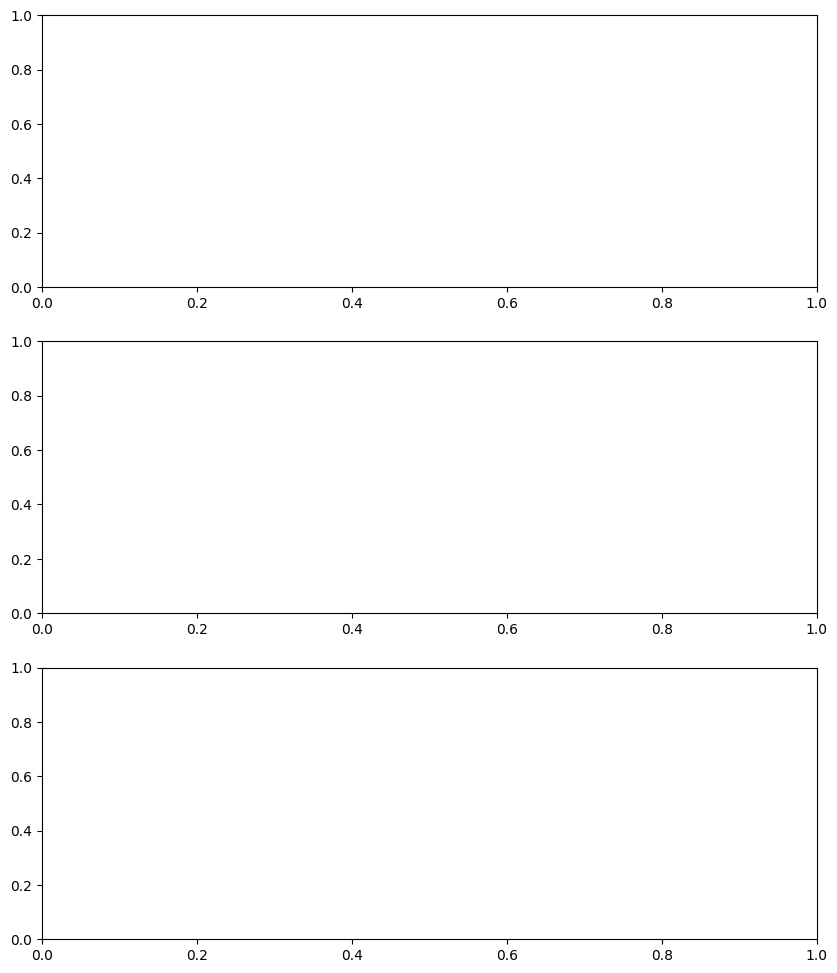

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(param_dict), ncols=1, figsize=(10, 4 * len(param_dict)))
if len(param_dict) == 1:
    axes = [axes]  # ensure axes is iterable for single plot

for ax, (p, h) in zip(axes, param_dict.items()):
    for key in h:    
        df = pd.read_csv(os.path.join(datapath, key + '_DES_data.csv'), sep=',', index_col='date')
        df.index = pd.to_datetime(df.index)
        df = df.merge(pv_df, left_index=True, right_index=True, how='left')
        df.rename(columns=columnname, inplace=True)
        df = df[req_clmns]

        chp_supply, boiler_supply, hp_supply, hrods_inb_supply = calc_energy([
            df['CHP_Pth'],
            df['Boilersim-0.BOILER_0-P_th'],
            df['HP_Q_Supplied'],
            df['HotWaterTankSim-2.HotWaterTank_0-hr_1.P_th']
        ])
        
        labels = ['CHP', 'Boiler', 'HP', 'Hrods']
        vals = [chp_supply, boiler_supply, hp_supply, hrods_inb_supply]

        ax.bar(labels, vals, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        ax.set_title(f'Energy Supply for {p}')
        ax.set_ylabel('Energy [kWh]')
        ax.grid(True)

plt.tight_layout()
plt.show()


# Single example


In [12]:
df = pd.read_csv(os.path.join(datapath, '_DES_data.csv'), sep=',', index_col='date')
df.index = pd.to_datetime(df.index)

In [ ]:
df = df.merge(pv_df, left_index=True, right_index= True, how = 'left')

In [13]:
dummy_df = pd.read_csv(os.path.join(datapath, '_DES_data.csv'), sep=',', index_col='date')
df.index = pd.to_datetime(df.index)

In [17]:
columnname = {'Power[w]': 'PV_P[W]', 'CSV-0.DNI_0-DNI': 'DNI', 'CSV-1.HEATLOAD_0-T_amb':'T_amb', 
              'HeatPumpSim-0.HeatPump_0-T_amb' : 'HP_Tamb', 
              'CSV-1.HEATLOAD_0-Heat Demand [kW]':'Heat Demand [KW]',
       'HeatPumpSim-0.HeatPump_0-Q_Demand' : 'HP_Q_Demand', 'CHPSim-0.CHP_0-Q_Demand':'CHP_Q_Demand',
       'HeatPumpSim-0.HeatPump_0-Q_Supplied' : 'HP_Q_Supplied',
       'HeatPumpSim-0.HeatPump_0-heat_source_T' : 'HP_heat_sourceT',
       'HeatPumpSim-0.HeatPump_0-cons_T' : 'HP_consT',
       'HeatPumpSim-0.HeatPump_0-P_Required': 'HP_P_Required', 'HeatPumpSim-0.HeatPump_0-COP':'HP_COP',
       'HeatPumpSim-0.HeatPump_0-cond_m':'HP_cond_m', 'HeatPumpSim-0.HeatPump_0-cond_in_T':'HP_cond_in_T',
       'HeatPumpSim-0.HeatPump_0-on_fraction':'HP_onfraction',
       'ControllerSim-0.Controller_0-heat_demand':'heat_demand',
       'ControllerSim-0.Controller_0-heat_supply':'heat_supply',
       'ControllerSim-0.Controller_0-hp_demand':'hp_demand',
       'ControllerSim-0.Controller_0-hp_supply':'hp_supply',
       'ControllerSim-0.Controller_0-chp_demand':'chp_demand',
       'ControllerSim-0.Controller_0-chp_supply':'chp_supply',
       'ControllerSim-0.Controller_0-heat_in_F':'heatin_F',
       'ControllerSim-0.Controller_0-heat_in_T':'heatin_T',
       'ControllerSim-0.Controller_0-heat_out_F':'heatout_F',
       'ControllerSim-0.Controller_0-heat_out_T':'heatout_T',
       'ControllerSim-0.Controller_0-chp_in_F':'chpin_F',
       'ControllerSim-0.Controller_0-chp_in_T':'chpin_T',
       'ControllerSim-0.Controller_0-chp_out_F':'chpout_F',
       'ControllerSim-0.Controller_0-chp_out_T':'chpout_T',
       'ControllerSim-0.Controller_0-hp_out_F':'hpout_F',
       'ControllerSim-0.Controller_0-hp_out_T':'hpout_T',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_00.T':'HWTSim0_sensor0_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_00.T':'HWTSim1_sensor0_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_00.T':'HWTSim2_sensor0_T',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_01.T':'HWTSim0_sensor1_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_01.T':'HWTSim1_sensor1_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_01.T':'HWTSim2_sensor1_T',
       'HotWaterTankSim-0.HotWaterTank_0-sensor_02.T':'HWTSim0_sensor2_T',
       'HotWaterTankSim-1.HotWaterTank_0-sensor_02.T':'HWTSim1_sensor2_T',
       'HotWaterTankSim-2.HotWaterTank_0-sensor_02.T':'HWTSim2_sensor2_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_out.T':'HWTSim0_heatout_T',
       'HotWaterTankSim-1.HotWaterTank_0-heat_out.T':'HWTSim1_heatout_T',
       'HotWaterTankSim-2.HotWaterTank_0-heat_out.T':'HWTSim2_heatout_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_out.F':'HWTSim0_heatout_F',
       'HotWaterTankSim-1.HotWaterTank_0-heat_out.F':'HWTSim1_heatout_F',
       'HotWaterTankSim-2.HotWaterTank_0-heat_out.F':'HWTSim2_heatout_F',
       'HotWaterTankSim-0.HotWaterTank_0-hp_in.T':'HWTSim0_hp_in_T',
       'HotWaterTankSim-1.HotWaterTank_0-hp_in.T':'HWTSim1_hp_in_T',
       'HotWaterTankSim-2.HotWaterTank_0-hp_in.T':'HWTSim2_hp_in_T',
       'HotWaterTankSim-0.HotWaterTank_0-hp_in.F':'HWTSim0_hp_in_F',
       'HotWaterTankSim-1.HotWaterTank_0-hp_in.F':'HWTSim1_hp_in_F',
       'HotWaterTankSim-2.HotWaterTank_0-hp_in.F':'HWTSim2_hp_in_F',
       'HotWaterTankSim-0.HotWaterTank_0-hp_out.T':'HWTSim0_hp_out_T',
       'HotWaterTankSim-1.HotWaterTank_0-hp_out.T':'HWTSim1_hp_out_T',
       'HotWaterTankSim-2.HotWaterTank_0-hp_out.T':'HWTSim2_hp_out_T',
       'HotWaterTankSim-0.HotWaterTank_0-hp_out.F':'HWTSim0_hp_out_F',
       'HotWaterTankSim-1.HotWaterTank_0-hp_out.F':'HWTSim1_hp_out_F',
       'HotWaterTankSim-2.HotWaterTank_0-hp_out.F':'HWTSim2_hp_out_F',
       'HotWaterTankSim-0.HotWaterTank_0-heat_in.T':'HWTSim0_heatin_T',
       'HotWaterTankSim-1.HotWaterTank_0-heat_in.T':'HWTSim1_heatin_T',
       'HotWaterTankSim-2.HotWaterTank_0-heat_in.T':'HWTSim2_heatin_T',
       'HotWaterTankSim-0.HotWaterTank_0-heat_in.F':'HWTSim0_heatin_F',
       'HotWaterTankSim-1.HotWaterTank_0-heat_in.F':'HWTSim1_heatin_F',
       'HotWaterTankSim-2.HotWaterTank_0-heat_in.F':'HWTSim2_heatin_F',
       'HotWaterTankSim-0.HotWaterTank_0-T_mean':'HWTSim0_Tmean',
       'HotWaterTankSim-1.HotWaterTank_0-T_mean':'HWTSim1_Tmean',
       'HotWaterTankSim-2.HotWaterTank_0-T_mean':'HWTSim2_Tmean', 'CHPSim-0.CHP_0-eff_el':'CHP_eff',
       'CHPSim-0.CHP_0-nom_P_th':'CHP_nom_Pth', 'CHPSim-0.CHP_0-mdot':'CHP_mdot',
       'CHPSim-0.CHP_0-mdot_neg':'CHP_mdot_neg', 'CHPSim-0.CHP_0-temp_in':'CHP_tempin',
       'CHPSim-0.CHP_0-temp_out':'CHP_tempout', 'CHPSim-0.CHP_0-P_th':'CHP_Pth', 'HeatPumpSim-0.HeatPump_0-Q_evap' : 'HP_Q_Evap'}

In [18]:
df.rename(columns=columnname, inplace= True)

In [19]:
req_clmns = ['PV_P[W]','Heat Demand [KW]', 'HP_Q_Demand', 'CHP_Q_Demand', 'CHP_Pth', 
             'HotWaterTankSim-2.HotWaterTank_0-hr_1.P_th', 'HP_Q_Supplied', 'HP_COP', 'Boilersim-0.BOILER_0-P_th', 
             'CHPSim-0.CHP_0-P_el', 'CHPSim-0.CHP_0-fuel_m3', 'Boilersim-0.BOILER_0-fuel_m3', 
             'ControllerSim-0.Controller_0-dhw_supply', 'ControllerSim-0.Controller_0-sh_supply', 'HP_P_Required']
df = df[req_clmns]

 * losses
 * total fuel consumption

In [21]:
chp_supply, boiler_supply, hp_supply, hrods_inb_supply = calc_energy([df['CHP_Pth'], df['Boilersim-0.BOILER_0-P_th'], df['HP_Q_Supplied'], df['HotWaterTankSim-2.HotWaterTank_0-hr_1.P_th']])


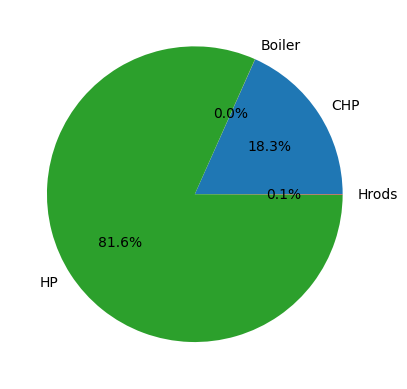

In [22]:
labels = ['CHP', 'Boiler', 'HP', 'Hrods']
vals = [chp_supply, boiler_supply, hp_supply, hrods_inb_supply]

plt.pie(vals, labels = labels, autopct='%1.1f%%')
plt.show()

In [23]:
# import plotly.express as px
# fig = px.pie(
#     names=labels,
#     values=vals,
#     title="Changed Parameters from JSON Files",
#     hole=0.3  # optional: to make it a donut chart
# )
# fig.show()

In [24]:
df['Household_demand'] = input_df['Electricity Demand [W]']

In [25]:

producers = {
    'PV': df['PV_P[W]'],
    'BHKW': df['CHPSim-0.CHP_0-P_el']}

users = {
    'Haushaltstrom': df['Household_demand'],
    'Wärmepumpe': df['HP_P_Required'],
    'Heizstäbe': df['HotWaterTankSim-2.HotWaterTank_0-hr_1.P_th']/0.98  #assuming heating rods efficiency 98, further work later
}
users_keys = list(users.keys())
producers_keys = list(producers.keys())
elec_links_df = pd.DataFrame({})
elec_links_df.index = df.index

In [26]:
netz = []
strom_gen = []
# could have zero value rows, indicating neutral
for r,ind in enumerate(df.index):
# for r in range(len(df)):
    supply = {k: producers[k][r] for k in producers}
    demand = {k: users[k][r] for k in users}

    for u_key in users_keys:
        for p_key in producers_keys:
            if demand[u_key] == 0:
                continue
            if supply[p_key] == 0:
                continue
            
            flow = min(demand[u_key], supply[p_key])
            supply[p_key] -= flow
            demand[u_key] -= flow


        # If unmet demand remains, take from grid
        if demand[u_key] > 0:
            elec_links_df.at[ind, f'Netz'] = demand[u_key]
            netz.append(demand[u_key])
    # Any leftover production goes to grid
    for p_key in producers_keys:
        if supply[p_key] > 0:
            elec_links_df.at[ind, f'Stromerzeugung'] = supply[p_key]
            strom_gen.append(supply[p_key])


In [27]:
sum(netz)*step_size/3600/10e6, sum(strom_gen)*step_size/3600/10e6

(53.593735234516046, 0.08792108354895707)

In [28]:
# the problem is with Nas, fill with 0, or just use the netz list!!
elec_links_df['Netz'].sum()* step_size/3600/10e6

11.69648481527155

In [29]:
df['tot_heat_supply'] = df['ControllerSim-0.Controller_0-sh_supply']+ df['ControllerSim-0.Controller_0-dhw_supply']

In [30]:
df['deficit'] = np.where(df['Heat Demand [KW]'] - df['tot_heat_supply'] > 0, df['Heat Demand [KW]'] - df['tot_heat_supply'], 0)

In [32]:
compare_results_df = pd.DataFrame([{
    'hash_key' : 'hash_here',
    'Parameters' : 'changedparam_val',
    'Net electricity(mWh)' : sum(netz)*step_size/3600/10e6,
    'Elec_gen(mWh)' : sum(strom_gen)*step_size/3600/10e6,
    'deficit' : df['deficit'].sum() * step_size/3600,
    'fuel_tot(m3)' : (df['CHPSim-0.CHP_0-fuel_m3'] + df['Boilersim-0.BOILER_0-fuel_m3']).sum() * step_size/3600,
    'HP_share' : hp_supply/sum(vals)*100
}])
compare_results_df

,hash_key,Parameters,Net electricity(mWh),Elec_gen(mWh),deficit,fuel_tot(m3),HP_share
0,hash_here,changedparam_val,53.593735,0.087921,0.0,2589.723235,81.618059
